# ID5059 P2 Group Project

### Imports

In [1]:
# use pip to install all the libraries we need
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn | grep -v 'already satisfied'

# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') # remove warnings

'grep' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


## Read in the data

In [2]:
# read the data, dropping the ID column, as this is duplicated by pandas
raw_training_data = pd.read_csv(r"train.csv").drop(columns=["id"])
raw_test_data = pd.read_csv(r"test.csv").drop(columns=["id"])

## Data analysis & Exploration

In [3]:
print(f"Train set shape: {raw_training_data.shape}") 
# print(f"Test set shape: {raw_test_data.shape}") # doesn't have the 'Status' column
# print()

Train set shape: (7905, 19)


In [4]:
print(f"Null count for both data sets:")
print(pd.concat([raw_training_data.isnull().sum().astype(float), raw_test_data.isnull().sum().astype(int)], axis=1).rename(columns={0: 'Train Set', 1: 'Test Set'}))

Null count for both data sets:
               Train Set  Test Set
N_Days               0.0       0.0
Drug                 0.0       0.0
Age                  0.0       0.0
Sex                  0.0       0.0
Ascites              0.0       0.0
Hepatomegaly         0.0       0.0
Spiders              0.0       0.0
Edema                0.0       0.0
Bilirubin            0.0       0.0
Cholesterol          0.0       0.0
Albumin              0.0       0.0
Copper               0.0       0.0
Alk_Phos             0.0       0.0
SGOT                 0.0       0.0
Tryglicerides        0.0       0.0
Platelets            0.0       0.0
Prothrombin          0.0       0.0
Stage                0.0       0.0
Status               0.0       NaN


In [5]:
print("Summary of numerical features:")
print(raw_training_data.describe().round(3))
print()

Summary of numerical features:
         N_Days        Age  Bilirubin  Cholesterol   Albumin    Copper  \
count  7905.000   7905.000   7905.000     7905.000  7905.000  7905.000   
mean   2030.173  18373.146      2.594      350.562     3.548    83.903   
std    1094.234   3679.959      3.813      195.379     0.346    75.899   
min      41.000   9598.000      0.300      120.000     1.960     4.000   
25%    1230.000  15574.000      0.700      248.000     3.350    39.000   
50%    1831.000  18713.000      1.100      298.000     3.580    63.000   
75%    2689.000  20684.000      3.000      390.000     3.770   102.000   
max    4795.000  28650.000     28.000     1775.000     4.640   588.000   

        Alk_Phos      SGOT  Tryglicerides  Platelets  Prothrombin     Stage  
count   7905.000  7905.000        7905.00   7905.000     7905.000  7905.000  
mean    1816.745   114.605         115.34    265.229       10.629     3.033  
std     1903.751    48.791          52.53     87.466        0.782   

In [6]:
print(pd.concat([raw_training_data.nunique().rename('Unique count'), raw_training_data.dtypes.rename('Data type'), ], axis=1))
print()

               Unique count Data type
N_Days                  461     int64
Drug                      2    object
Age                     391     int64
Sex                       2    object
Ascites                   2    object
Hepatomegaly              2    object
Spiders                   2    object
Edema                     3    object
Bilirubin               111   float64
Cholesterol             226   float64
Albumin                 160   float64
Copper                  171   float64
Alk_Phos                364   float64
SGOT                    206   float64
Tryglicerides           154   float64
Platelets               227   float64
Prothrombin              49   float64
Stage                     4   float64
Status                    3    object



In [7]:
print("Proportion of each response variable:")
print(raw_training_data['Status'].value_counts() / np.shape(raw_training_data)[0])
print()

Proportion of each response variable:
Status
C     0.628083
D     0.337128
CL    0.034788
Name: count, dtype: float64



##### Unique Drug Values

In [8]:
# Check unique values in the 'Drug' column
unique_drugs = raw_training_data['Drug'].unique()
print("Unique drugs in the dataset:", unique_drugs)

Unique drugs in the dataset: ['D-penicillamine' 'Placebo']


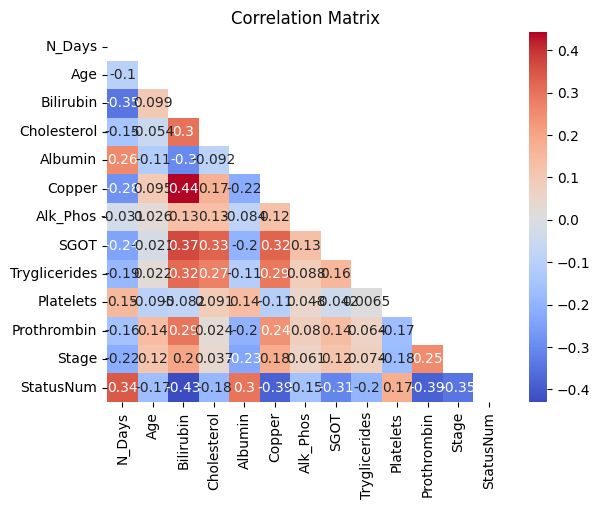

In [9]:
# convert Status response to numerical for correlation exploration
response_map = {'D':0, 'CL':1, 'C':2}
raw_training_data['StatusNum'] = raw_training_data['Status'].map(response_map)

matrix = raw_training_data[raw_training_data.select_dtypes(include=['int64', 'float64']).columns].corr() # define correlation matrix
train = raw_training_data.drop(columns=['StatusNum']) # drop the numerical Status label
diagmask = np.triu(np.ones_like(matrix)) # create mask to only map lower diagonal
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask=diagmask) # plot the heatmap
plt.title('Correlation Matrix')
plt.show()

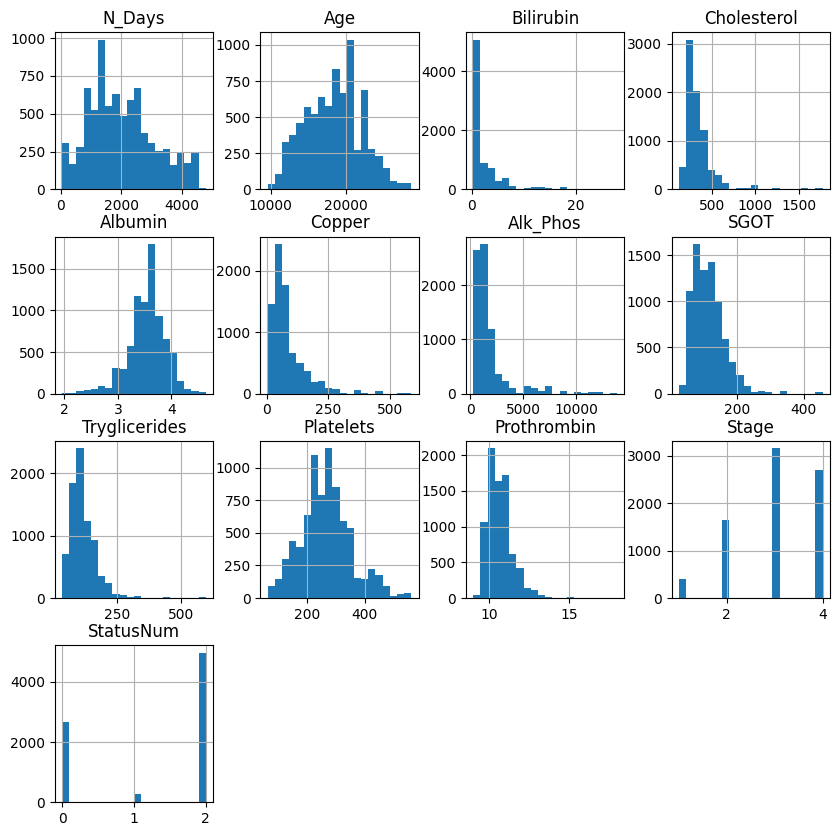

In [10]:
# plot histograms for numerical variables
raw_training_data.hist(bins=20, figsize=(10, 10))
plt.show()

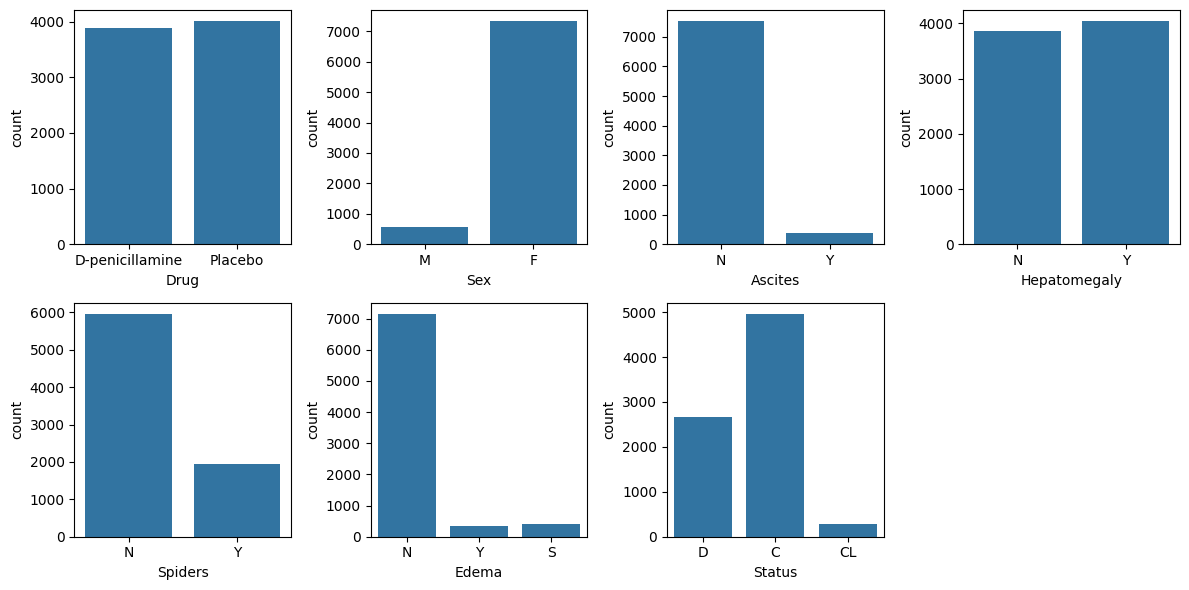

In [11]:
# plot countplots for categorical variables
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6)) # initialise figure and axes
axs = axs.flatten()

categorical = train.select_dtypes(include='object').columns # store the categorical variables
for i in range(len(categorical)): # loop over categorical variables
    sns.countplot(x=categorical[i], data=raw_training_data, ax=axs[i]) # countplot for each variable
[ax.remove() for ax in axs[7:]] # remove final axis
plt.tight_layout()

##### Class Distribution Visualization

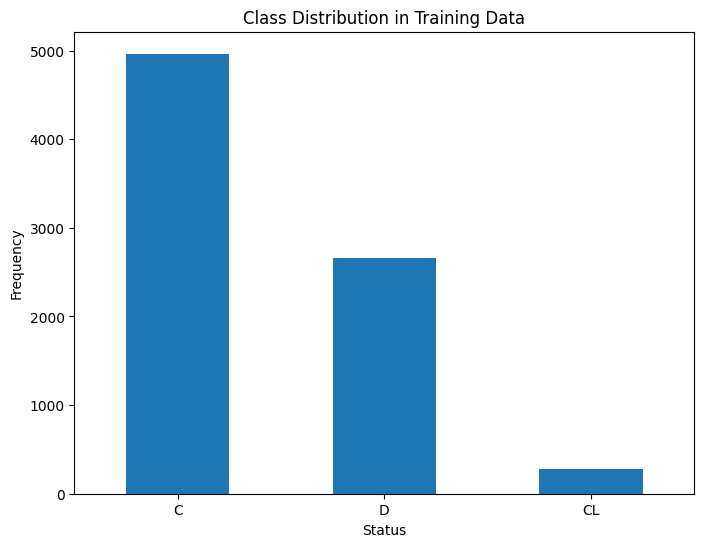

In [12]:
plt.figure(figsize=(8, 6))
raw_training_data['Status'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

##### Feature Distribution by Class

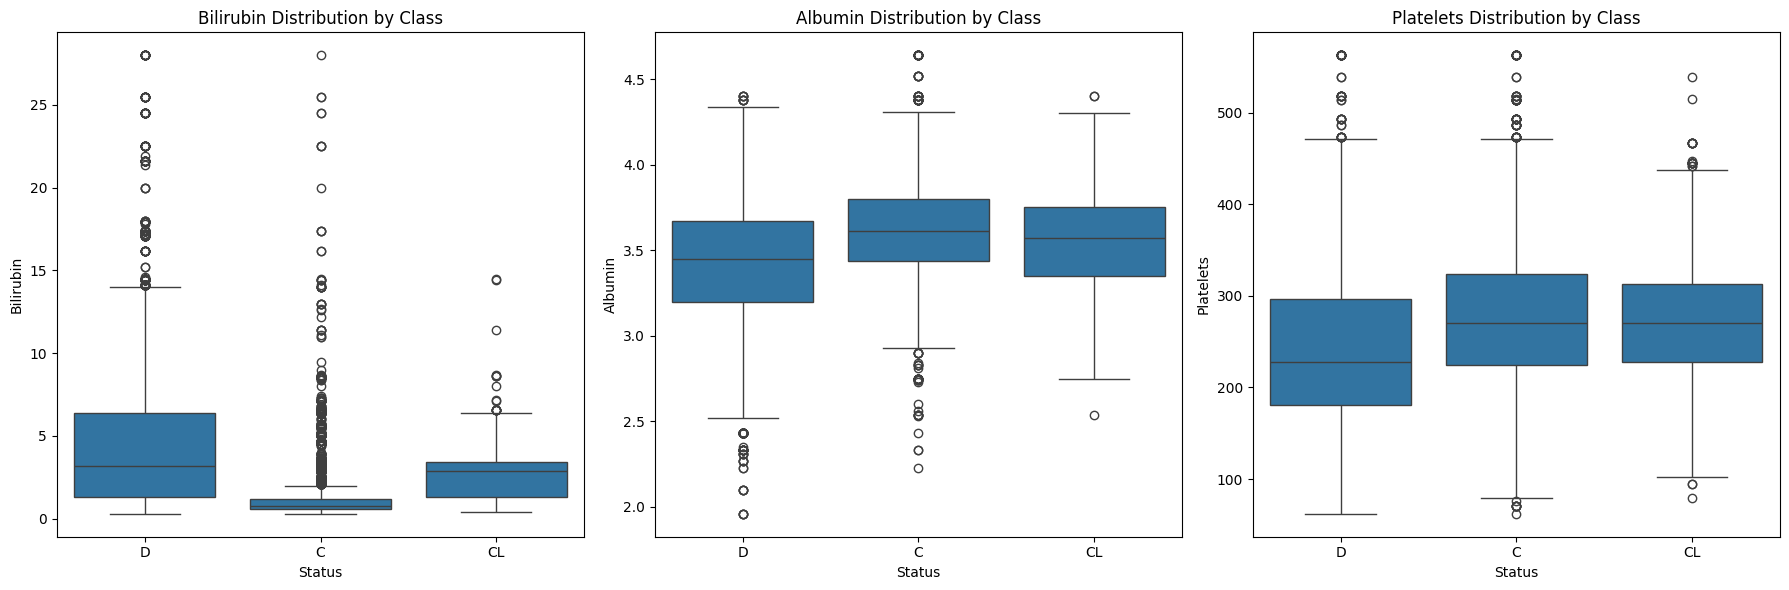

In [13]:
# Feature Distribution by Class for 'Bilirubin', 'Albumin', and 'Platelets'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(ax=axes[0], x='Status', y='Bilirubin', data=raw_training_data)
sns.boxplot(ax=axes[1], x='Status', y='Albumin', data=raw_training_data)
sns.boxplot(ax=axes[2], x='Status', y='Platelets', data=raw_training_data)
axes[0].set_title('Bilirubin Distribution by Class')
axes[1].set_title('Albumin Distribution by Class')
axes[2].set_title('Platelets Distribution by Class')
plt.tight_layout()
plt.show()

##### Correlation Analysis Extended

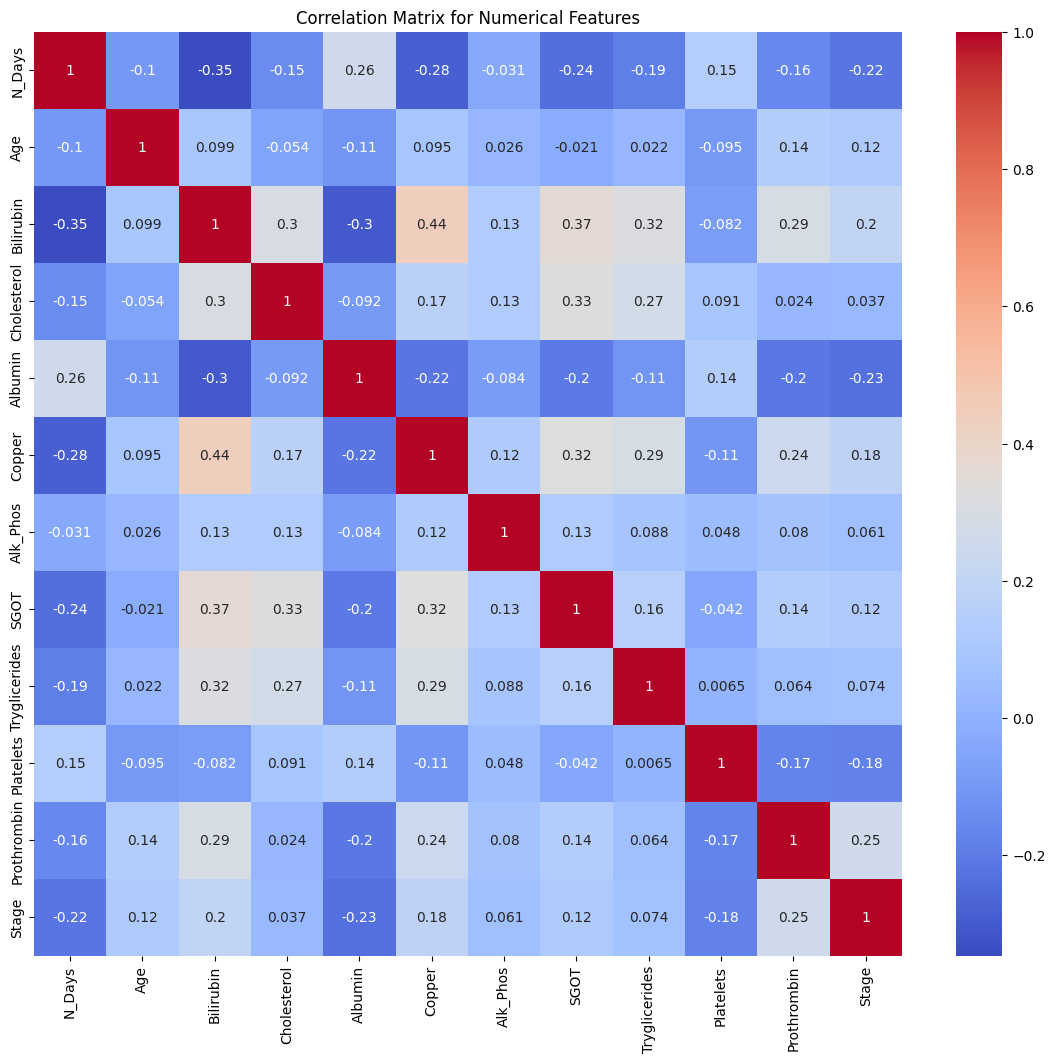

In [14]:
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

plt.figure(figsize=(14, 12))
sns.heatmap(raw_training_data[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

##### Outlier Detection for Key Numerical Features

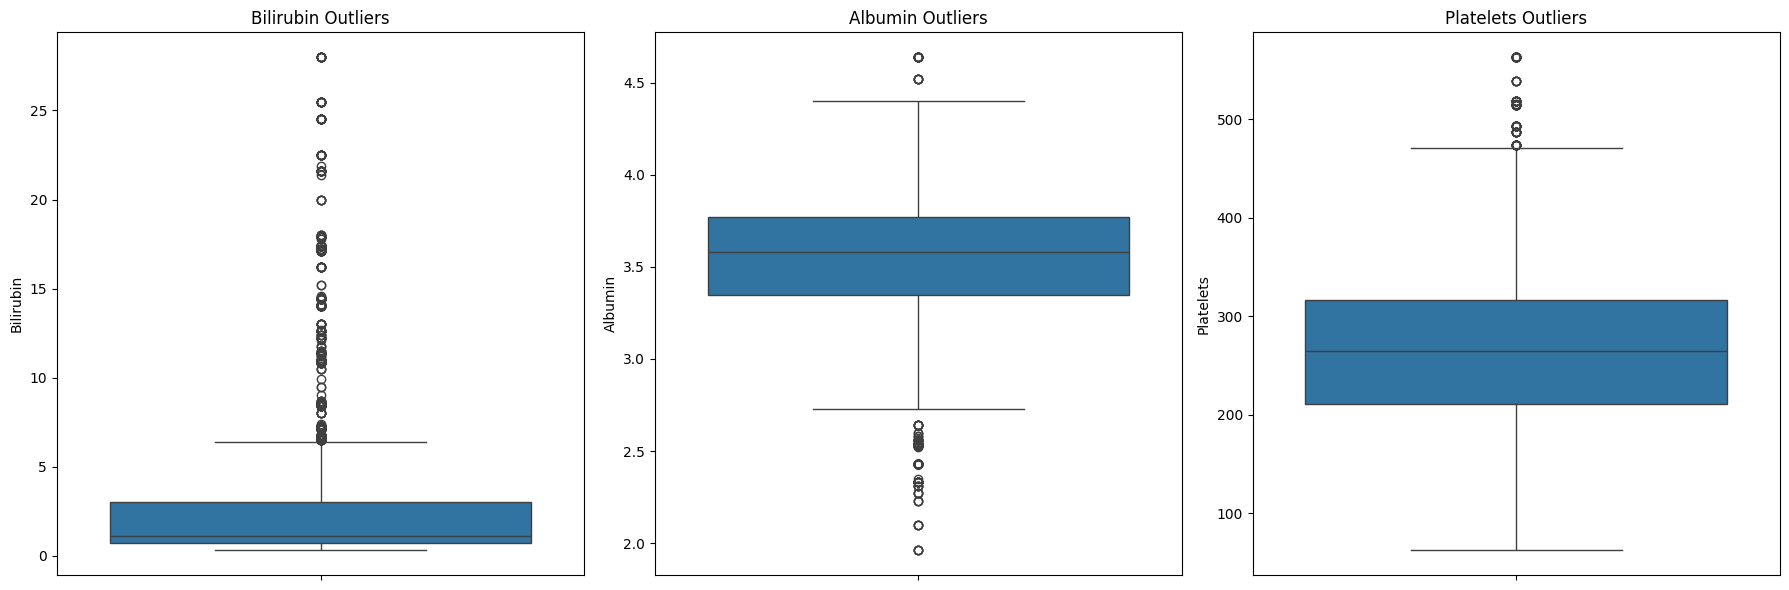

In [15]:
# Outlier Detection for 'Bilirubin', 'Albumin', and 'Platelets'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(ax=axes[0], data=raw_training_data['Bilirubin'], orient="v")
sns.boxplot(ax=axes[1], data=raw_training_data['Albumin'], orient="v")
sns.boxplot(ax=axes[2], data=raw_training_data['Platelets'], orient="v")
axes[0].set_title('Bilirubin Outliers')
axes[1].set_title('Albumin Outliers')
axes[2].set_title('Platelets Outliers')
plt.tight_layout()
plt.show()

##### Exploring Categorical Features

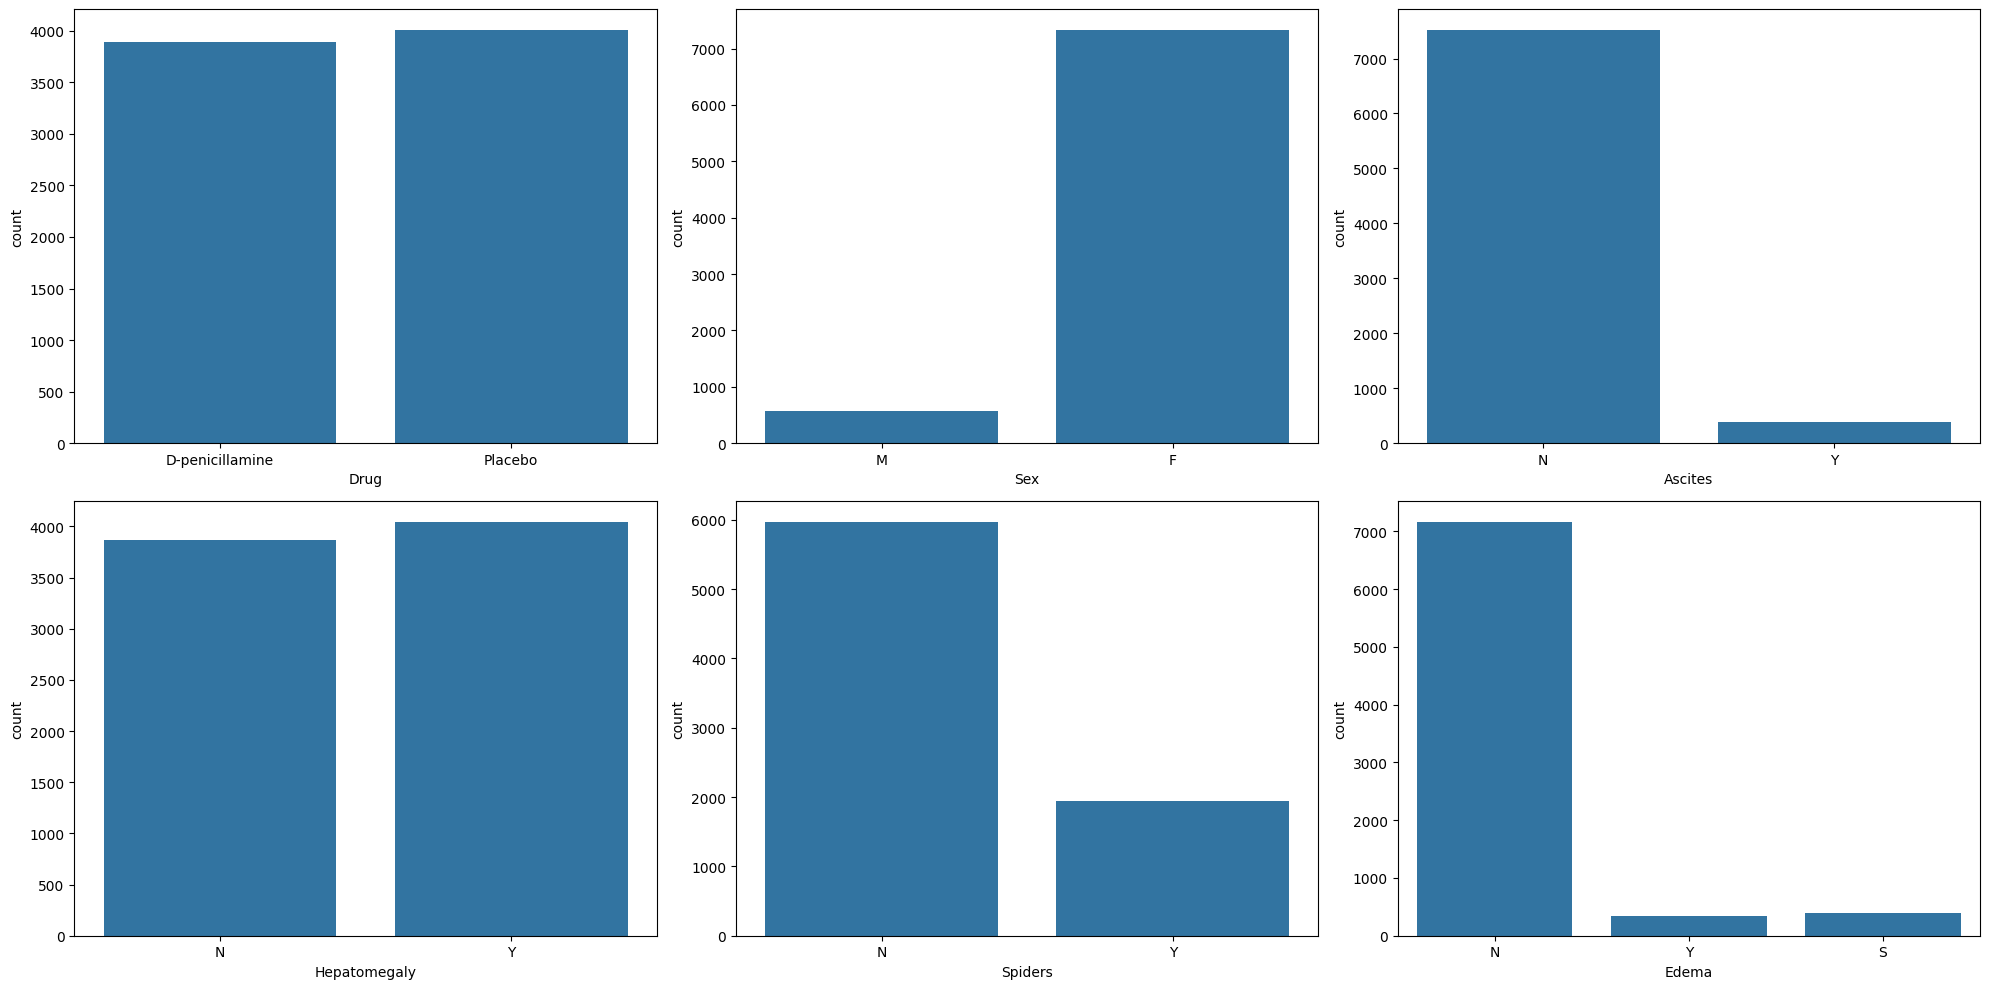

In [16]:
# Categorical Features Distribution
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, cat_feature in enumerate(categorical_features):
    sns.countplot(x=cat_feature, data=raw_training_data, ax=axes[i])
plt.tight_layout()
plt.show()

##### Interaction Effects Between Features

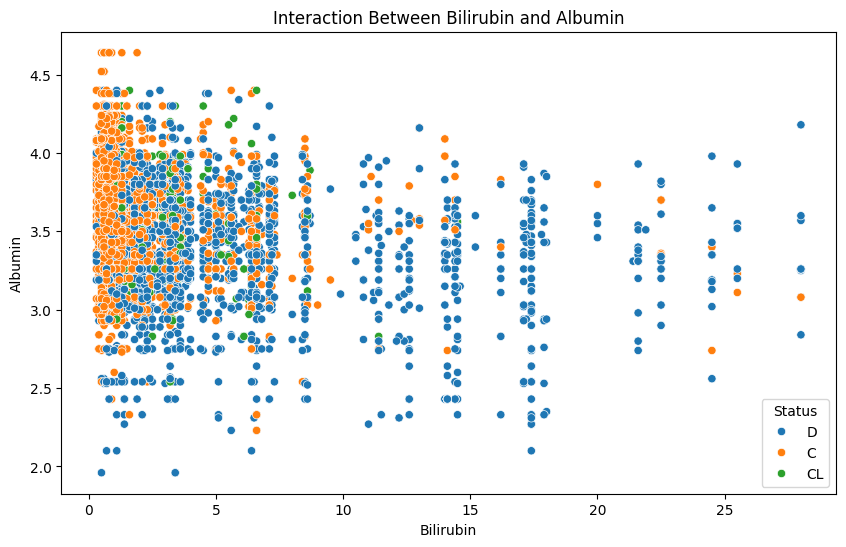

In [17]:
# Interaction Effects Between 'Bilirubin' and 'Albumin'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bilirubin', y='Albumin', hue='Status', data=raw_training_data)
plt.title('Interaction Between Bilirubin and Albumin')
plt.show()

##### Feature Distribution Comparison Between Classes

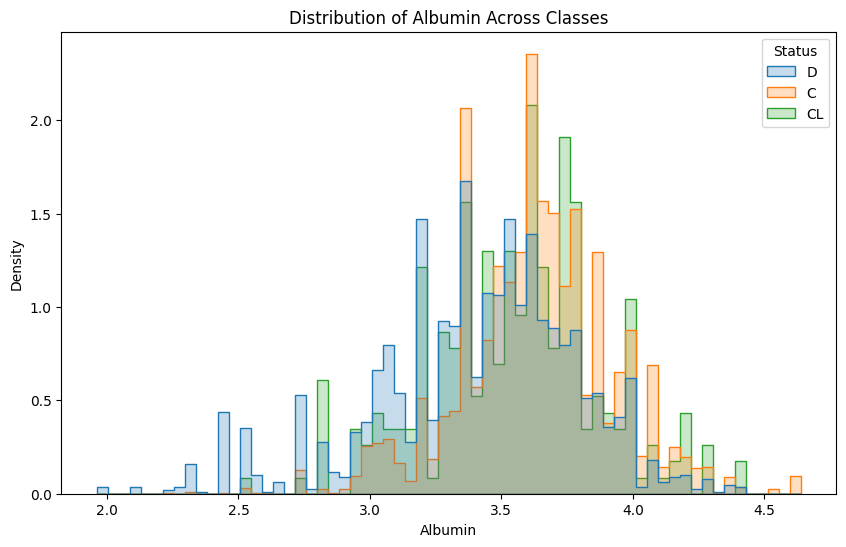

In [18]:
# Distribution of 'Albumin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Albumin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Albumin Across Classes')
plt.show()

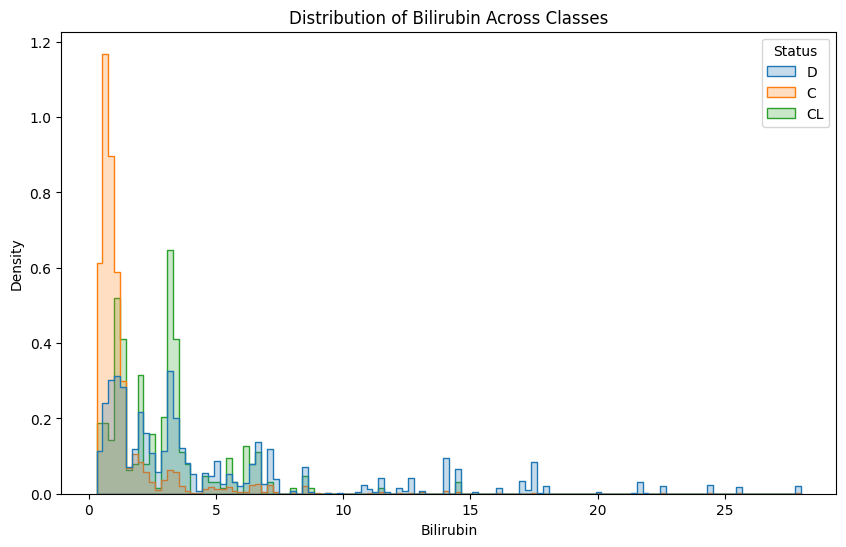

In [19]:
# Distribution of 'Bilirubin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Bilirubin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Bilirubin Across Classes')
plt.show()

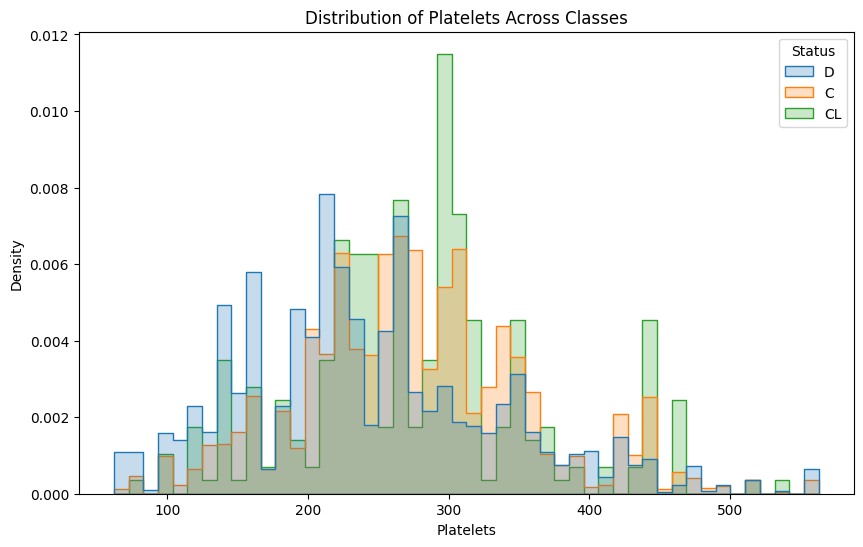

In [20]:
# Distribution of 'Platelets' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Platelets', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Platelets Across Classes')
plt.show()

##### Advanced Visualization of Categorical Variables

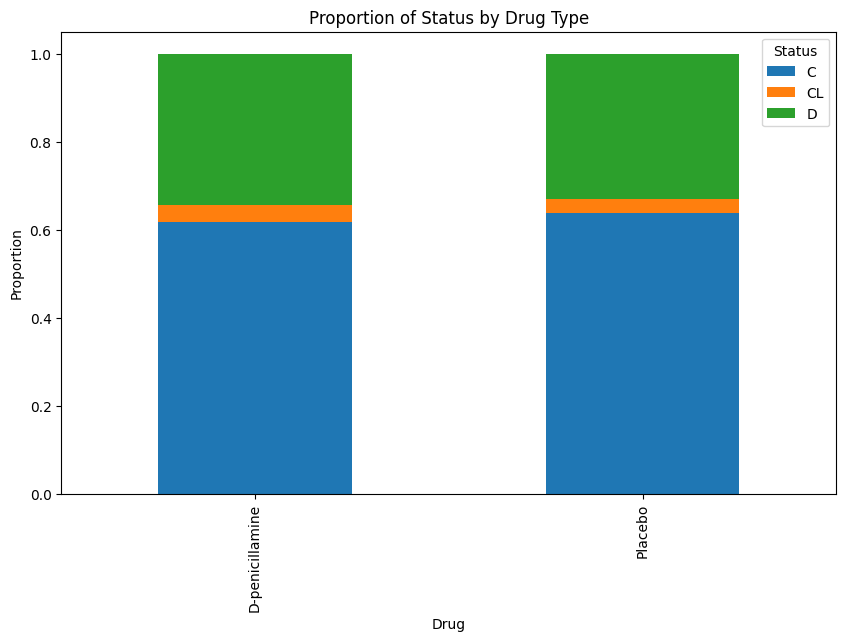

In [21]:
# Stacked Bar Chart for 'Drug' and 'Status'
cross_tab = pd.crosstab(index=raw_training_data['Drug'], columns=raw_training_data['Status'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Status by Drug Type')
plt.ylabel('Proportion')
plt.show()

### Imputation Methods

What we need to do:
* Select three imputation methods
* Make a copy of the training data
* Remove a randomly selected proportion of the data values
* Impute missing values and compare results to original data

## Pipeline

The pipeline will handle:
- Data Cleaning
- Feature Engineering
- Unbalanced Data
- Scaling/Normalization
- Imputation Placeholder

HAS NOT BEEN RUN YET WILL PROB ERROR IF YOU RUN THE WHOLE DOCUMENT BECUSE ITS MISSING THE IMPUTATION AND OTHER THINGS

In [23]:
# Imports for pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # Placeholder for imputation
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline

In [ ]:
# Function for cleaning data
def clean_data(data):
    """
    Cleans the dataset by applying imputation methods and handling outliers.

    Parameters:
    - data: pandas DataFrame containing the data to be cleaned.

    Returns:
    - The cleaned pandas DataFrame.
    """
    # IMPUTATION METHOD HERE
    # handle outliers:
    high = np.percentile(df["Bilirubin"], 95)  # 95th percentile
    df["Bilirubin"] = np.where(df["Bilirubin"] > high, high, df["Bilirubin"])

    high_copper = np.percentile(df["Copper"], 95)  # 95th percentile
    df["Copper"] = np.where(df["Copper"] > high_copper, high_copper, df["Copper"])

    return data


# Function for transforming numerical features
def transform_numerical(data):
    """
    Applies transformations to numerical features to address skewness and improve
    interpretability.

    Parameters:
    - data: pandas DataFrame with the numerical features to be transformed.

    Returns:
    - The DataFrame with transformed numerical features.
    """
    # Log transformation to address skewness
    data["Bilirubin"] = np.log(data["Bilirubin"] + 1).astype(float)
    data["Copper"] = np.log(data["Copper"] + 1).astype(float)
    data["Alk_Phos"] = np.log(data["Alk_Phos"] + 1).astype(float)
    data["SGOT"] = np.log(data["SGOT"] + 1).astype(float)

    # Normalize Age to be in years for better interpretability
    data["Age_in_Years"] = (data["Age"] / 365.25).astype(float)
    data.drop("Age", axis=1, inplace=True)

    # Add other numerical transformations here
    return data


# Function for transforming categorical features
def transform_categorical(data):
    """
    Transforms categorical features into numerical format suitable for machine
    learning models.

    Parameters:
    - data: pandas DataFrame with the categorical features to be transformed.

    Returns:
    - The DataFrame with transformed categorical features.
    """
    data["Is_Male"] = (data["Sex"] == "M").astype(float)
    data.drop("Sex", axis=1, inplace=True)
    # Add other categorical transformations here if needed
    return data


# Define the columns to keep
columns_to_keep = [
    "N_Days", "Age_in_Years", "Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
    "Stage", "Drug", "Is_Male", "Ascites", "Hepatomegaly", "Spiders", 
    "Edema", "Status",
]

# Numerical and categorical features
numerical_features = [
    "N_Days", "Age_in_Years","Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", 
    "Prothrombin", "Stage",
]

# Updated categorical features list after transformations
categorical_features = [ "Drug", "Ascites", "Hepatomegaly", 
                        "Spiders", "Edema",
    # 'Sex' has been transformed to 'Is_Male', which is now a numerical feature]
]

# Pipeline for numerical features
numerical_pipeline = Pipeline(
    steps=[
        ("transformer", FunctionTransformer(transform_numerical)),
        ("scaler", StandardScaler()),
    ]
)

# Pipeline for categorical features
categorical_pipeline = Pipeline(
    steps=[
        ("transformer", FunctionTransformer(transform_categorical)),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Column transformer for applying different pipelines to different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features),
    ]
)

# Complete pipeline with cleaning, preprocessing, and balancing (SMOTE) for training data
full_pipeline_train = imblearnPipeline(
    steps=[
        ("cleaner", FunctionTransformer(clean_data, validate=False)),  # Data cleaning step
        ("preprocessor", preprocessor),  # Preprocessing (numerical and categorical transformations)
        ("smote", SMOTE(random_state=42)),  # Handling unbalanced data
    ]
)
full_pipeline.set_output(transform="pandas")

# Complete pipeline with cleaning, preprocessing, but without balancing (SMOTE) for test data
full_pipeline_test = imblearnPipeline(
    steps=[
        ("cleaner", FunctionTransformer(clean_data, validate=False)),  # Data cleaning step
        ("preprocessor", preprocessor),  # Preprocessing (numerical and categorical transformations)
    ]
)
full_pipeline.set_output(transform="pandas")

prepared_training_data = full_pipeline_train.fit_transform(raw_training_data)
prepared_test_data = full_pipeline_test.transform(raw_test_data)

## Model Training and Validation

Splitting prepared training data into training and validation sets

In [ ]:
# make sure to split the training data here 80/20 for training 
# and validation (use  shuffle)

# Separate features and target variable from the training data
X = prepared_training_data.drop(['Status'], axis=1)
y = prepared_training_data['Status']

# Splitting data into training(80%) and validation(20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0, stratify=y_train)

# the quantity in training and validation set 
print("Number of training sets:", len(X_train), "Number of validation sets:", len(X_val))
print("Number of training target:", len(y_train), "Number of validation target:", len(y_val))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

SVM model

In [ ]:
# SVM model 
svm_clf = LinearSVC(C=1, loss="hinge", class_weight='balanced', random_state=42, max_iter=2000)

# Training the model
svm_clf.fit(X_train, y_train)

Evaluate SVM model performance

In [ ]:
# Predict validation set data
y_pred_SVM = svm_clf.predict(X_val)

# precision, recall, f1-score, accuracy
report_SVM = classification_report(y_val, y_pred_SVM, zero_division=0)
print(report_SVM)

In [ ]:
# cross validation
scores_SVM = cross_val_score(svm_clf, X_train, y_train,cv=3, scoring="accuracy") # splitting the training set into 3 folds
print(scores_SVM)

In [ ]:
# Calculate the confusion matrix on the valid data
matrix_val_tree_svm = confusion_matrix(y_val, y_pred_SVM)

# Visualizing the confusion matrices
plt.figure(figsize=(7, 7))
sns.heatmap(matrix_val_tree_svm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 12})
plt.title('SVM Confusion Matrix')

plt.show()

Random forest model

In [ ]:
# Define the RandomForest model
random_forest_clf= RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

# Train the RandomForest model
random_forest_clf.fit(X_train, y_train)

Evaluate random forest model performance

In [ ]:
# Predicting on validation set with RandomForest
y_pred_random_forest = random_forest_clf.predict(X_val)

# precision, recall, f1-score, accuracy
report_random_forest = classification_report(y_val, y_pred_random_forest, zero_division=0)
print(report_random_forest)

In [ ]:
# cross validation
scores_random_forest = cross_val_score(random_forest_clf, X_train, y_train,cv=3, scoring="accuracy") # splitting the training set into 3 folds
print(scores_random_forest)

In [ ]:
# Calculate the confusion matrix on the valid data
matrix_val_tree_rf = confusion_matrix(y_val, y_pred_random_forest)

# Visualizing the confusion matrices
plt.figure(figsize=(7, 7))
sns.heatmap(matrix_val_tree_rf, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 12})
plt.title('random forest Confusion Matrix')

plt.show()

## Testing

## Hyperparameter Optimization